
# Autoencoder

In this notebook, you will implement an autoencoder. An autoencoder seeks to learn a latent representation of our training images by using unlabeled data and learning to reconstruct its inputs.

In [1]:
# DO NOT MODIFY THIS CELL!
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from visualize_util import visualize_img_batch, plot_latent_space, plot_latent_space_images

In [5]:
# Use this if you are using any Cuda enabled system
if torch.cuda.is_available():
    device = 'cuda'
# elif torch.backends.mps.is_available():
#     device = 'mps' 
else:
    device = 'cpu'
print(device)

cpu


In [6]:
# Use this only if you are running on M1/M2 macbooks
dtype = torch.float
device = torch.device(device)
device

device(type='cpu')

## Load MNIST Dataset


We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9).

We will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `data`. 

In [10]:
#TODO
hidden_dim = 300 
latent_dim = 2
batch_size = 64 
n_epochs = 15

# TODO, convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

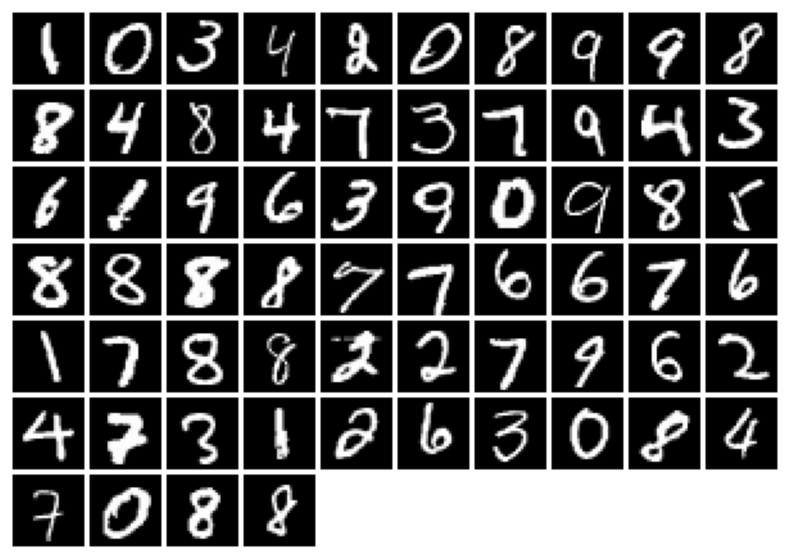

In [11]:
imgs = next(iter(loader_train))[0].numpy().squeeze()
visualize_img_batch(imgs)

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim, input_dim):
        super(Autoencoder, self).__init__()
        output_dim = input_dim
        #TODO
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim),
            # nn.LeakyReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
            # nn.LeakyReLU()
        )

    def forward(self, x):
        #TODO
        x = x.to(device)
        # print(x.shape)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
from torchsummary import summary
autoencoder = Autoencoder(latent_dim, hidden_dim,784).to(device)
summary(autoencoder,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
         LeakyReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 300]          90,300
         LeakyReLU-5                  [-1, 300]               0
            Linear-6                    [-1, 2]             602
            Linear-7                  [-1, 300]             900
         LeakyReLU-8                  [-1, 300]               0
            Linear-9                  [-1, 300]          90,300
        LeakyReLU-10                  [-1, 300]               0
           Linear-11                  [-1, 784]         235,984
Total params: 653,586
Trainable params: 653,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [15]:
criterion = nn.MSELoss() # TODO: specify loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3) # TODO: specify optimizer

for epoch in range(n_epochs):
    train_loss = 0
    for x, y in loader_train:
        optimizer.zero_grad()
        output = autoencoder(x)
        x = x.view(x.size(0), -1).to(device)
        loss = criterion(x, output)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(loader_train)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.048120
Epoch: 1 	Training Loss: 0.042397
Epoch: 2 	Training Loss: 0.040801
Epoch: 3 	Training Loss: 0.039673
Epoch: 4 	Training Loss: 0.038867
Epoch: 5 	Training Loss: 0.038237
Epoch: 6 	Training Loss: 0.037988
Epoch: 7 	Training Loss: 0.037557
Epoch: 8 	Training Loss: 0.037167
Epoch: 9 	Training Loss: 0.037120
Epoch: 10 	Training Loss: 0.036864
Epoch: 11 	Training Loss: 0.036802
Epoch: 12 	Training Loss: 0.036480
Epoch: 13 	Training Loss: 0.036541
Epoch: 14 	Training Loss: 0.036364


In [16]:
autoencoder.checkpoint = autoencoder
torch.save(autoencoder, 'autoencoder.pth')

In [17]:
autoencoder = torch.load('autoencoder.pth')

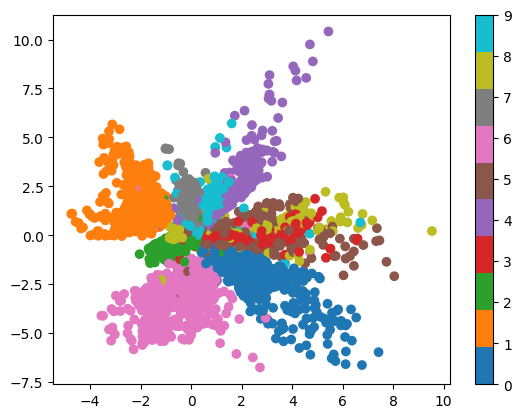

In [18]:
# show latent space distribution
plot_latent_space(autoencoder.encoder, loader_train, device)

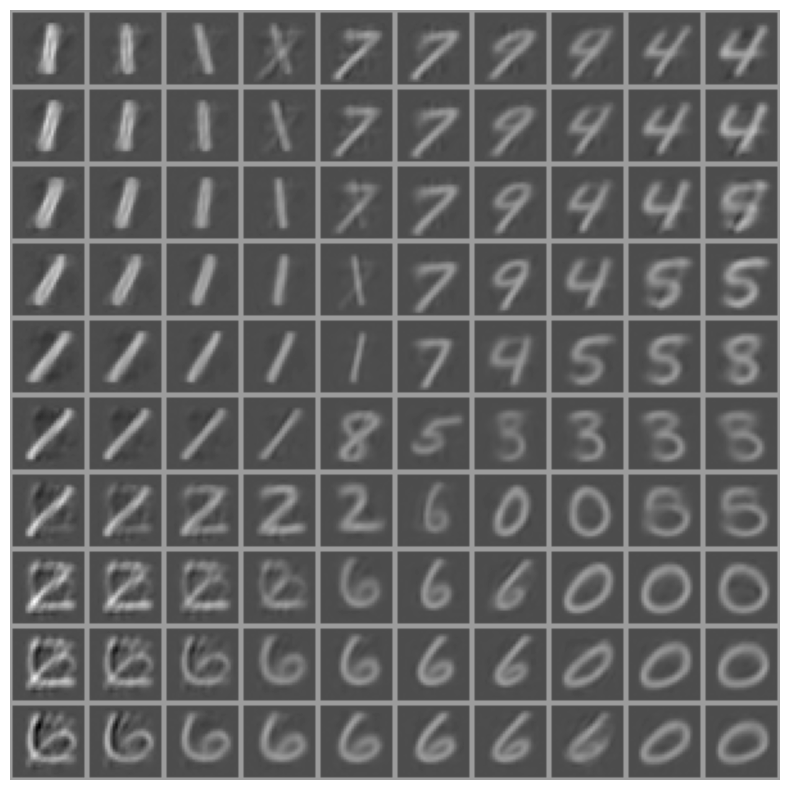

In [19]:
# show reconstruction from latent space images
plot_latent_space_images(autoencoder.decoder, device)